We gonna do an Exploratory Data Analysis and a Random Forest model based on a two Amazon stock datasets

In [1]:
from helpers import *
from plotnine import *
from stldecompose import decompose, forecast

pd.set_option('display.max_columns', 500)

import warnings
warnings.simplefilter("ignore")

In [2]:
df = merge_data(price_file="data/price_amzn.csv", 
                fundamental_file="data/fund_amzn.csv")

### EDA

In [3]:
df.reset_index(inplace=True)
variables = list(df.columns)[1:]
mdf = pd.melt(df, id_vars='date')

In [4]:
mdf.head()

,date,variable,value
0,2009-06-26,open,81.90
1,2009-07-10,open,77.52
2,2009-07-17,open,85.80
3,2009-07-24,open,87.60
4,2009-07-31,open,85.76


In [5]:
df.set_index("date", inplace=True)

In [6]:
col = 'adjdilutedeps'
short_term_trend = 'ma_1y_{}'.format(col)
long_term_trend = 'ma_3y_{}'.format(col)
short_term_stdev = 'std_1y_{}'.format(col)

df[short_term_trend] = df[col].rolling(4*12, center=False, win_type=None, closed="right").mean()
df[long_term_trend] = df[col].rolling(4*12*3, center=False, win_type=None, closed="right").mean()
df[short_term_stdev] = df[col].rolling(4*12, center=False, win_type=None, closed="right").std()

df[[col, short_term_trend, long_term_trend]].tail()

,adjdilutedeps,ma_1y_adjdilutedeps,ma_3y_adjdilutedeps
date,,,
2018-11-30,6.05,4.960417,2.573819
2018-12-07,6.05,5.008333,2.608403
2018-12-14,6.05,5.066250,2.642986
2018-12-21,6.05,5.124167,2.677569
2018-12-28,6.05,5.182083,2.712153


In [7]:
df2 = df.reset_index()
mdf2 = df2[["date", col, short_term_trend, long_term_trend, short_term_stdev]].melt(id_vars='date')

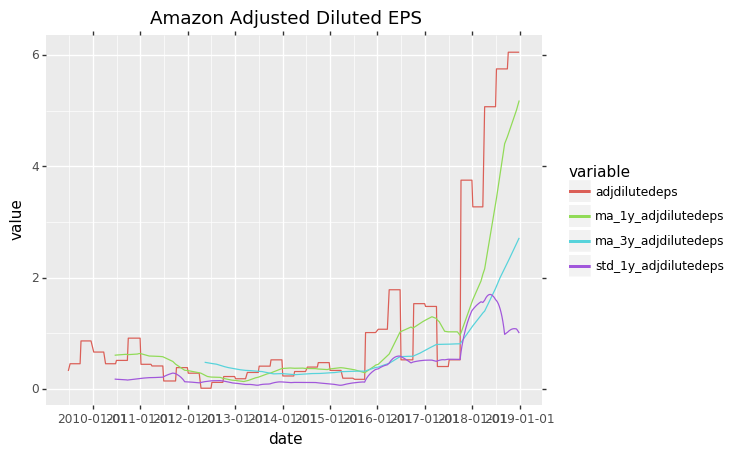

<ggplot: (8776040863331)>

In [8]:
ggplot(mdf2, aes(x="date", y="value", color="variable")) + geom_line() + labs(title= "Amazon Adjusted Diluted EPS")

With Decomp we will decompose the plot into Level, Trend, Seasonality and Noise

In [9]:
decomp = decompose(df[col], period=53)

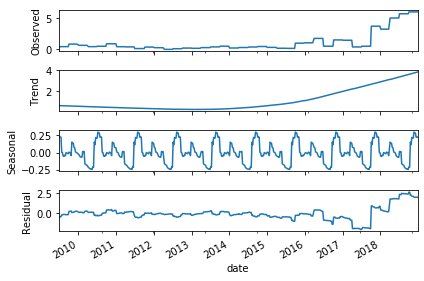

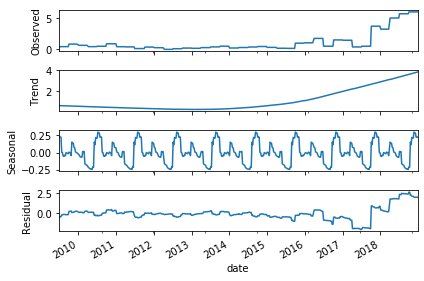

In [33]:
decomp.plot()

Here we can see that The Adjusted Diluted EPS seems to be a very good aproximation to the Trend 

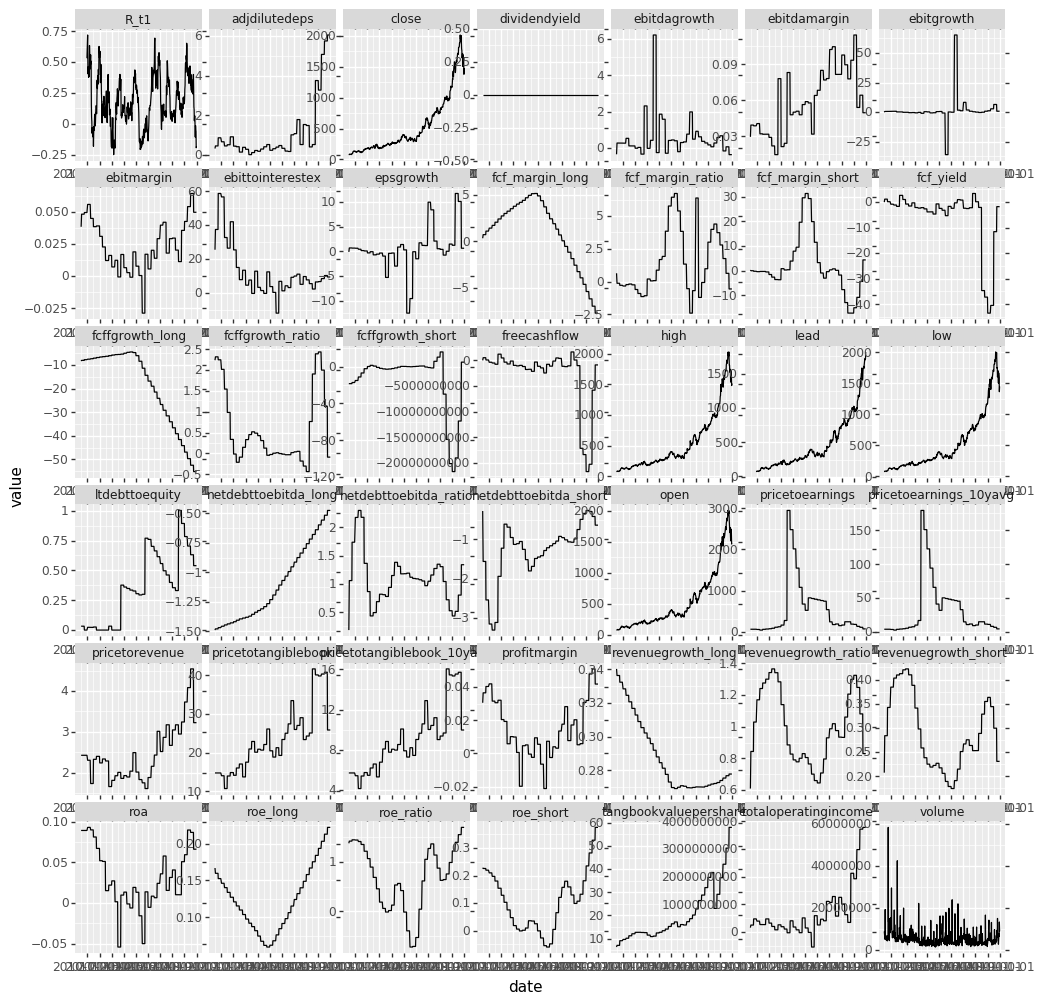

<ggplot: (-9223363260814361326)>

In [11]:
df.reset_index(inplace=True)
ggplot(mdf, aes(x="date", y="value")) + geom_line() + facet_wrap("~variable", scales="free") + theme(figure_size=(12, 12))

We chose some relevant features as predictors

In [12]:
predictors = ['pricetorevenue', 'roe_ratio', 'ebitmargin', 'epsgrowth', 
                'pricetotangiblebook', 'roe_short', 'ebittointerestex', 
                'fcffgrowth_short', 'profitmargin', 'fcffgrowth_ratio',
                'ebitgrowth', 'fcf_margin_short', 'roa', 'fcf_margin_ratio', 
                'revenuegrowth_ratio', "adjdilutedeps"]


response = ['R_t1']

In [13]:
df.head()

,date,open,high,low,close,volume,R_t1,pricetoearnings,pricetotangiblebook,adjdilutedeps,dividendyield,fcf_yield,pricetorevenue,pricetoearnings_10yavg,pricetotangiblebook_10yavg,ebitmargin,ebitdamargin,profitmargin,freecashflow,totaloperatingincome,roa,roe_short,roe_long,roe_ratio,fcf_margin_short,fcf_margin_long,fcf_margin_ratio,ebitdagrowth,ebitgrowth,epsgrowth,tangbookvaluepershare,revenuegrowth_short,revenuegrowth_long,revenuegrowth_ratio,fcffgrowth_short,fcffgrowth_long,fcffgrowth_ratio,ltdebttoequity,ebittointerestex,netdebttoebitda_short,netdebttoebitda_long,netdebttoebitda_ratio,lead,ma_1y_adjdilutedeps,ma_3y_adjdilutedeps,std_1y_adjdilutedeps
0,2009-06-26,81.90,84.14,81.13,83.88,8775300,NaN,65.9178,14.7795,0.32,0,-0.065096,2.426,4.011014,5.687923,0.038271,0.029456,0.030531,-28642458.1,159000000.0,0.089357,0.228871,0.166920,1.371148,0.202145,0.316696,0.638294,-0.344498,-0.148325,-0.135135,6.375000,0.207361,0.340260,0.609419,-18.569391,-8.303538,2.236323,0.0335,25.4286,-0.274236,-1.488387,0.18425,NaN,NaN,NaN,NaN
1,2009-07-10,77.52,78.82,76.17,77.63,5976100,NaN,65.9178,14.7795,0.45,0,1.119091,2.426,4.011014,5.687923,0.048082,0.039273,0.036520,493519084.0,251000000.0,0.089357,0.225971,0.159718,1.414815,-0.087082,0.701864,-0.124073,0.273810,0.471910,0.666667,7.092971,0.283839,0.336341,0.843901,-18.540579,-8.000766,2.317351,0.0324,37.4286,-1.564014,-1.478219,1.05804,NaN,NaN,NaN,NaN
2,2009-07-17,85.80,86.50,85.20,85.85,5051600,NaN,65.9178,14.7795,0.45,0,1.119091,2.426,4.011014,5.687923,0.048082,0.039273,0.036520,493519084.0,251000000.0,0.089357,0.225971,0.159718,1.414815,-0.087082,0.701864,-0.124073,0.273810,0.471910,0.666667,7.092971,0.283839,0.336341,0.843901,-18.540579,-8.000766,2.317351,0.0324,37.4286,-1.564014,-1.478219,1.05804,NaN,NaN,NaN,NaN
3,2009-07-24,87.60,88.90,85.50,86.49,19204600,NaN,65.9178,14.7795,0.45,0,1.119091,2.426,4.011014,5.687923,0.048082,0.039273,0.036520,493519084.0,251000000.0,0.089357,0.225971,0.159718,1.414815,-0.087082,0.701864,-0.124073,0.273810,0.471910,0.666667,7.092971,0.283839,0.336341,0.843901,-18.540579,-8.000766,2.317351,0.0324,37.4286,-1.564014,-1.478219,1.05804,NaN,NaN,NaN,NaN
4,2009-07-31,85.76,86.75,84.62,85.76,5886900,NaN,65.9178,14.7795,0.45,0,1.119091,2.426,4.011014,5.687923,0.048082,0.039273,0.036520,493519084.0,251000000.0,0.089357,0.225971,0.159718,1.414815,-0.087082,0.701864,-0.124073,0.273810,0.471910,0.666667,7.092971,0.283839,0.336341,0.843901,-18.540579,-8.000766,2.317351,0.0324,37.4286,-1.564014,-1.478219,1.05804,NaN,NaN,NaN,NaN


In [14]:
df.set_index("date", inplace=True)

In [15]:
train = df["20100101":"20161231"]
test = df["20170101":"20190101"]

#train.isnull().sum(axis=0)


In [16]:
X_train = train[predictors].values
y_train = train[response].values
X_test = test[predictors].values
y_test = test[response].values

### Random Forest model 

We start by evaluating how well a simple random forest model works and later on we tune the main parameters

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
rf = RandomForestRegressor(
    n_estimators=200, max_depth=6, max_features=0.5, 
    oob_score=True)

In [19]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [20]:
rf.oob_score_

def MAE(y_true, y_pred):
    return np.mean( np.abs( (y_true - y_pred) ) ) 

In [21]:
yhat = rf.predict(X_test)

We find that the model has a mean absolute error of 0.1485. This means that on average the mean error in absolute terms is 14,85% from the 6 month return. 

In [22]:
MAE(y_test, yhat)

0.14737411081823718

In [23]:
y_test.mean()

0.22404475468032647

In [24]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 6, 8, 10, 12],
    'max_features': [0.1, 0.25, 0.5],
    'n_estimators': [50, 100, 250, 500]
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [25]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.9s finished


{'bootstrap': True, 'max_depth': 12, 'max_features': 0.1, 'n_estimators': 50}

In [26]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features=0.1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [27]:
yhat = grid_search.predict(X_test)

Using GridSearch improves the performance of the model by reducing the MAE to 0.1456

In [28]:
MAE(y_test, yhat)

0.1519409430610979

In [29]:
rf = RandomForestRegressor(
        n_estimators=250, max_depth=4, max_features=0.1, 
        oob_score=True)
rf.fit(X_train, y_train)
yhat = rf.predict(X_test)
MAE(y_test, yhat)

0.14560586355752012

In [30]:
rf.oob_score_

0.6364342695262555

In [31]:
rf.feature_importances_.shape

(16,)

In our model, these are the features ordered hierarchically by importance.

In [32]:
imp = pd.DataFrame(dict(var=predictors, imp=rf.feature_importances_))
imp.sort_values('imp', ascending=False)

,var,imp
3,epsgrowth,0.080754
0,pricetorevenue,0.073377
4,pricetotangiblebook,0.072679
11,fcf_margin_short,0.069226
15,adjdilutedeps,0.067021
1,roe_ratio,0.066735
8,profitmargin,0.062743
2,ebitmargin,0.062263
10,ebitgrowth,0.062001
5,roe_short,0.059389


This result sounds consistent since variables such as Price / Revenue, EPS Growth, EBIT growth, which are closely related, obtain a very similar level of importance. 
In the same way we see that the Adjusted Diluted EPS variable is a good predictor of the movement of the Amazon share price, which is consistent with what we saw in the EDA.